In [53]:
import pandas as pd
import numpy as np

## Reading and Combing Data

In [2]:
fake_df = pd.read_csv('DataSet_Misinfo_FAKE.csv', encoding='latin_1', usecols=["text"], nrows=10000)
true_df = pd.read_csv('DataSet_Misinfo_TRUE.csv', encoding='latin_1', usecols=["text"], nrows=10000)

In [3]:
fake_df['truth'] = 0
true_df['truth'] = 1
df = pd.concat([fake_df, true_df], ignore_index=True, axis=0)
df.dropna(inplace=True)

In [4]:
fake_df = None
true_df = None

In [5]:
df.text= df.text.str.replace(r'[^A-Za-z0-9]+', ' ')

c:\users\toby\python\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


## Vectorizing Data

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
vectorizer = CountVectorizer(min_df=5, max_features=2000, 
                             ngram_range=(1,2),
                             stop_words='english',
                             dtype='uint8'
                            )
doc_vec = vectorizer.fit_transform(df.text)

print(doc_vec.shape)

(19971, 2000)


In [8]:
features = vectorizer.get_feature_names_out()

In [9]:
X = pd.DataFrame(doc_vec.toarray(),columns=features)
y = df.truth

In [10]:
X.head()

,000,10,100,11,12,13,14,15,16,17,...,year old,years,years ago,yes,york,york city,york times,young,youtube,zero
0,0,0,0,1,0,0,0,0,0,0,...,2,3,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Data Visualization

In [50]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

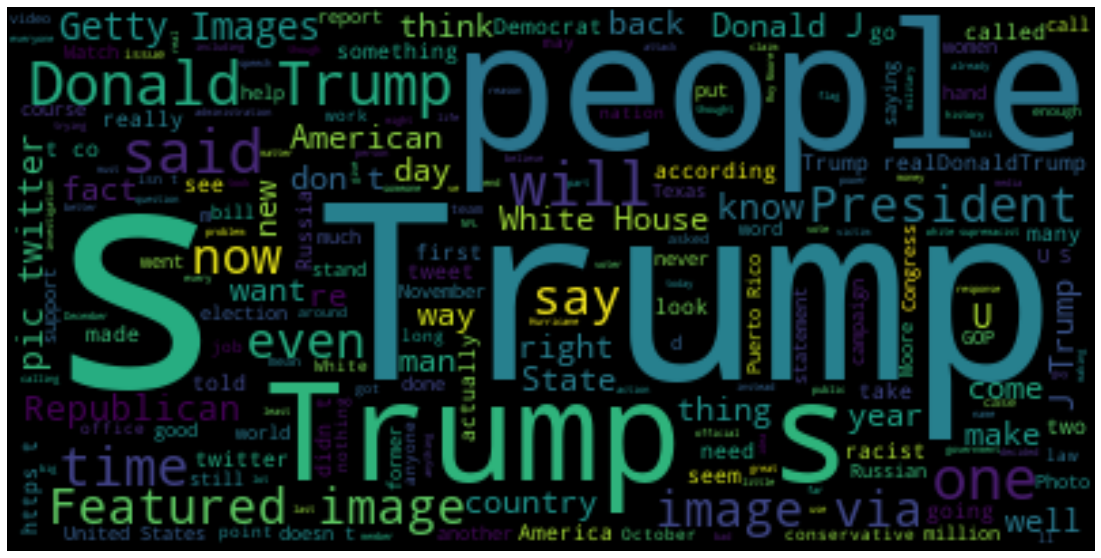

In [22]:
text = ' '.join(df[df.truth == 0].head(500).text)

wordcloud = WordCloud().generate(text)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

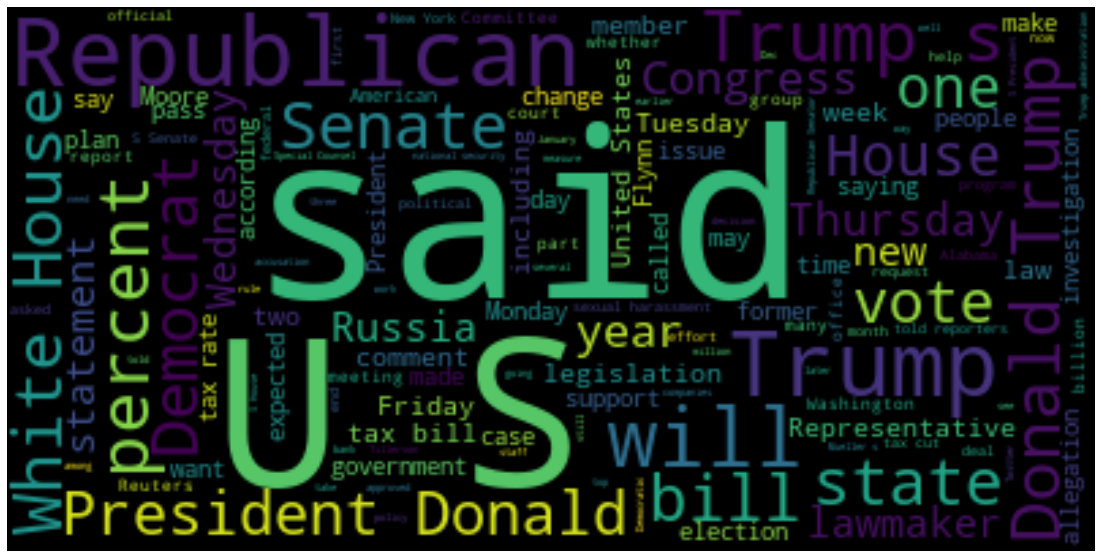

In [23]:
text = ' '.join(df[df.truth == 1].head(500).text)

wordcloud = WordCloud().generate(text)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Naive Bayes

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)

In [25]:
mnb = MultinomialNB()

In [26]:
mnb.fit(X_train,y_train)

MultinomialNB()

In [12]:
from sklearn.metrics import plot_confusion_matrix

c:\users\toby\python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 1080x1080 with 0 Axes>

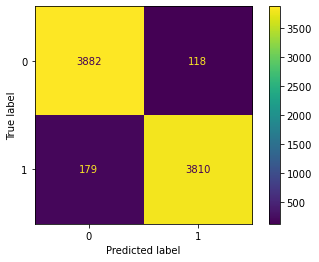

In [48]:
plt.figure(figsize=(15,15))
ax = plot_confusion_matrix(mnb, X_test, y_test)  
plt.show()

In [13]:
from sklearn.model_selection import cross_validate

In [50]:
acc = cross_validate(mnb, X, y, cv=5)

In [52]:
acc['test_score'].mean()

0.945269782019713

## SVM

In [14]:
from sklearn.svm import SVC

In [15]:
svc = SVC(kernel="linear")

In [17]:
svc.fit(doc_vec,y)

SVC(kernel='linear')

In [20]:
acc = cross_validate(svc, doc_vec, y, cv=5)

In [21]:
acc['test_score'].mean()

0.9726598533595137

## Feature Importance

In [27]:
neg_df = pd.DataFrame()
neg_df['log_likelihood'] = mnb.feature_log_prob_[0] - mnb.feature_log_prob_[1]
neg_df['word'] = features
print('Most untruthful words')
print(neg_df.sort_values(by=['log_likelihood']).tail(10))
print('===============================')

pos_df = pd.DataFrame()
pos_df['log_likelihood'] = mnb.feature_log_prob_[1] - mnb.feature_log_prob_[0]
pos_df['word'] = features
print('Most truthful words')
print(pos_df.sort_values(by=['log_likelihood']).tail(10))

Most untruthful words
      log_likelihood                  word
1600        6.274615            screenshot
26          6.498097  2017 realdonaldtrump
1598        6.577411        screen capture
826         7.145561                 https
1280        7.546294           pic twitter
1878        7.553855           twitter com
1279        7.563694                   pic
731         7.671010          getty images
730         7.698274                 getty
654         8.328782        featured image
Most truthful words
      log_likelihood              word
912         3.202024            jan 20
428         3.232412              corp
1568        3.271269       said friday
1234        3.285255          overhaul
1527        3.296436           reuters
1572        3.310399     said thursday
1575        3.371687    said wednesday
493         3.532352  declined comment
1178        4.138488      nov election
1824        4.476649      told reuters


In [28]:
ax = pos_df.sort_values(by=['log_likelihood']).tail(20).plot.barh(x="word")

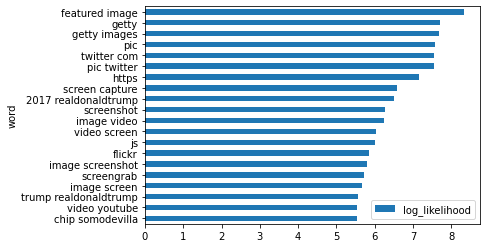

In [29]:
ax = neg_df.sort_values(by=['log_likelihood']).tail(20).plot.barh(x="word")

## Visualize SVM

In [55]:
pos_features = pos_df.sort_values(by=['log_likelihood']).tail(1)['word'].to_list()

In [56]:
neg_features = neg_df.sort_values(by=['log_likelihood']).tail(1)['word'].to_list()

In [57]:
cols = pos_features
cols.extend(neg_features)

In [58]:
svc_small = SVC(kernel="linear")

In [59]:
svc_small.fit(X[cols],y)

SVC(kernel='linear')

In [60]:
svc_small.support_vectors_

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

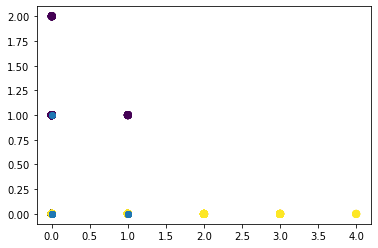

In [61]:
plt.scatter(X[cols].iloc[:, 0], X[cols].iloc[:, 1], c=y, s=50)
plt.scatter(svc_small.support_vectors_[:,0],svc_small.support_vectors_[:,1])

c:\users\toby\python\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


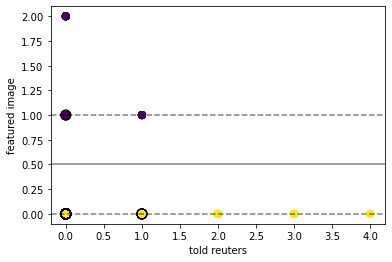

In [64]:
ax = plt.gca()
ax.set_xlabel('told reuters')
ax.set_ylabel('featured image')
plt.scatter(X[cols].iloc[:, 0], X[cols].iloc[:, 1], c=y, s=50)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svc_small.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

ax.scatter(svc_small.support_vectors_[:, 0], svc_small.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()